<a href="https://colab.research.google.com/github/IvanKatorgin/Computer-vision/blob/main/%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Компьютерное зрение". Домашнее задание 2. Обучение сверточной сети на практике. Каторгин И.П.

## Описание задания

Классификация изображений: Cats vs Dogs

Обучить модель классификации изображений на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука для решения можно скачать по ссылке https://github.com/a4tunado/lectures/tree/master/006. Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.

Датасет https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.18.0
True


Подключимся к kaggle и загрузим датасет

In [2]:
! pip install -q kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                           title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
anandshaw2001/netflix-movies-and-tv-shows                     Netflix Movies and TV Shows                         1MB  2025-01-03 10:33:01          14256        369  1.0              
asinow/car-price-dataset                                      Car Price Dataset                                 135KB  2025-01-26 19:53:28           3729         52  1.0              
ankushpanday1/alzheimers-prediction-dataset-global            Alzheimer’s Prediction Dataset (Global)             1MB  2025-01-30 14:38:39           1560         33  1.0              
asinow/airplane-price-dataset                                 Airplane Price Dat

In [7]:
# загрузим данные из Kaggle
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

100% 812M/814M [00:31<00:00, 27.0MB/s]
100% 814M/814M [00:31<00:00, 26.9MB/s]


In [8]:
# проверка
! unzip -l dogs-vs-cats-redux-kernels-edition.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
   113903  2019-12-11 04:18   sample_submission.csv
284478493  2019-12-11 04:18   test.zip
569918665  2019-12-11 04:18   train.zip
---------                     -------
854511061                     3 files


In [9]:
# загрузка
! unzip dogs-vs-cats-redux-kernels-edition.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [10]:
# загрузка тестовой и обучающей выборки
! unzip test.zip
! unzip train.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/d

## Функции загрузки данных

In [11]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('train/*.jpg')
test_files = glob('test/*.jpg')

# Загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[..., ::-1]  # Чтение и преобразование BGR -> RGB
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # Предобработка для VGG16

# Функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = -j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# Функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    for path in files:
      img = load_image(path)  # Загружаем и предобрабатываем изображение
      yield (np.expand_dims(img, axis=0),)  # Добавляем размерность батча

## Визуализируем примеры для обучения

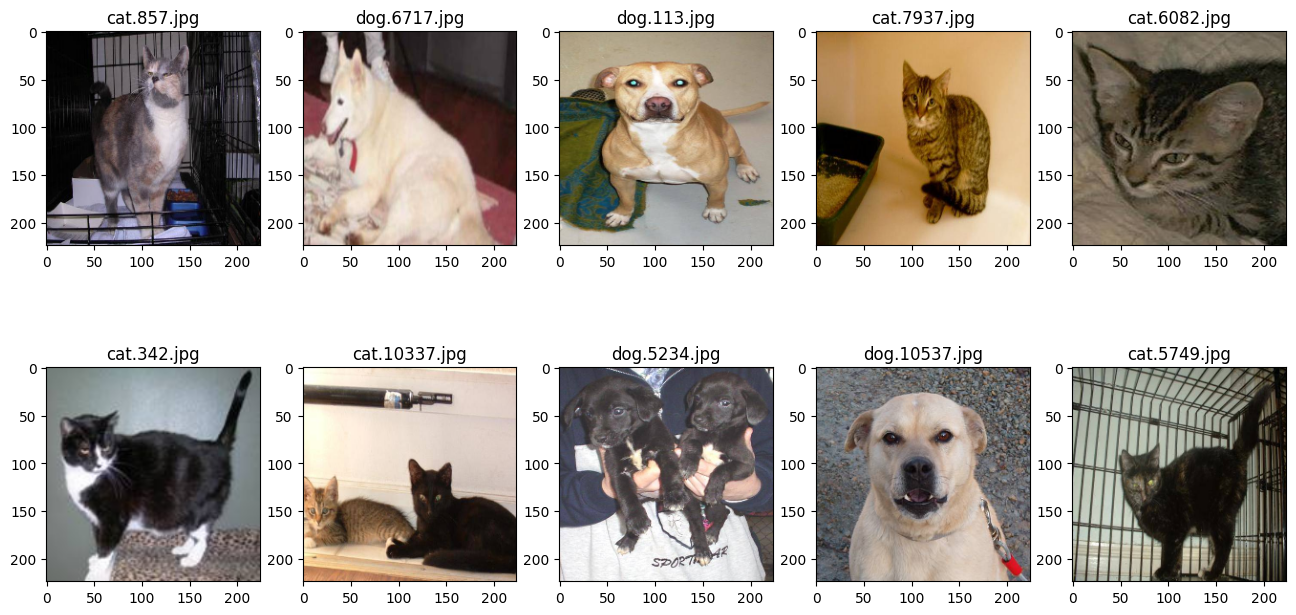

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [13]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [14]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Добавляем полносвязный слой

In [15]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [16]:
model.summary()

Model: "dogs_vs_cats"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,326,913 (127.13 MB)

 Trainable params: 25,691,137 (98.00 MB)

 Non-trainable params: 7,635,776 (29.13 MB)

## Компилируем модель и запускаем обучение

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [18]:
test_size = 0.3
batch_size = 32

In [19]:
val_samples = int(test_size * len(train_files))  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = fit_generator(train_files[:val_samples], batch_size=batch_size)
train_data = fit_generator(train_files[val_samples:], batch_size=batch_size)  # данные читаем функцией-генератором

# Запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
#          steps_per_epoch=(len(train_files[val_samples:]) // batch_size),  # число вызовов генератора за эпоху - так считает слишком долго
          epochs=25,  # число эпох обучения
          validation_data=validation_data,
#          validation_steps=(len(train_files[:val_samples]) // batch_size # слишком долго считает)
          validation_steps=5)

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 321s 33s/step - accuracy: 0.6556 - loss: 0.6753 - val_accuracy: 0.7625 - val_loss: 2.0437
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 316s 33s/step - accuracy: 0.8166 - loss: 0.3631 - val_accuracy: 0.8188 - val_loss: 0.6400
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 326s 34s/step - accuracy: 0.8407 - loss: 0.3515 - val_accuracy: 0.8687 - val_loss: 0.3260
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 318s 33s/step - accuracy: 0.8804 - loss: 0.3373 - val_accuracy: 0.9375 - val_loss: 0.1755
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 382s 40s/step - accuracy: 0.8682 - loss: 0.3249 - val_accuracy: 0.9000 - val_loss: 0.2338
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 315s 33s/step - accuracy: 0.9011 - loss: 0.2339 - val_accuracy: 0.8687 - val_loss: 0.2838
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 321s 33s/step - accuracy: 0.8797 - loss: 0.3047 - val_accuracy: 0.8938 - val_loss: 0.2494
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 314s 33s/step - accuracy: 0.9150 - loss: 0.2131 - val_accuracy: 0.

In [20]:
model.save('cats-dogs-vgg16.keras')

## Предсказания на проверочной выборке

In [21]:
# Предсказание на тестовых данных
test_pred = model.predict(
    predict_generator(test_files),
    steps=len(test_files))

print(test_pred[:10])

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 7922s 634ms/step
[[0.04361569]
 [0.9345259 ]
 [1.        ]
 [0.9724139 ]
 [0.03999195]
 [0.11860287]
 [0.9855998 ]
 [0.33126095]
 [0.011224  ]
 [0.00404054]]


<ipython-input-22-fb6ddecd4396>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  subplot.set_title('%.2f %s' % (score, os.path.basename(path)))


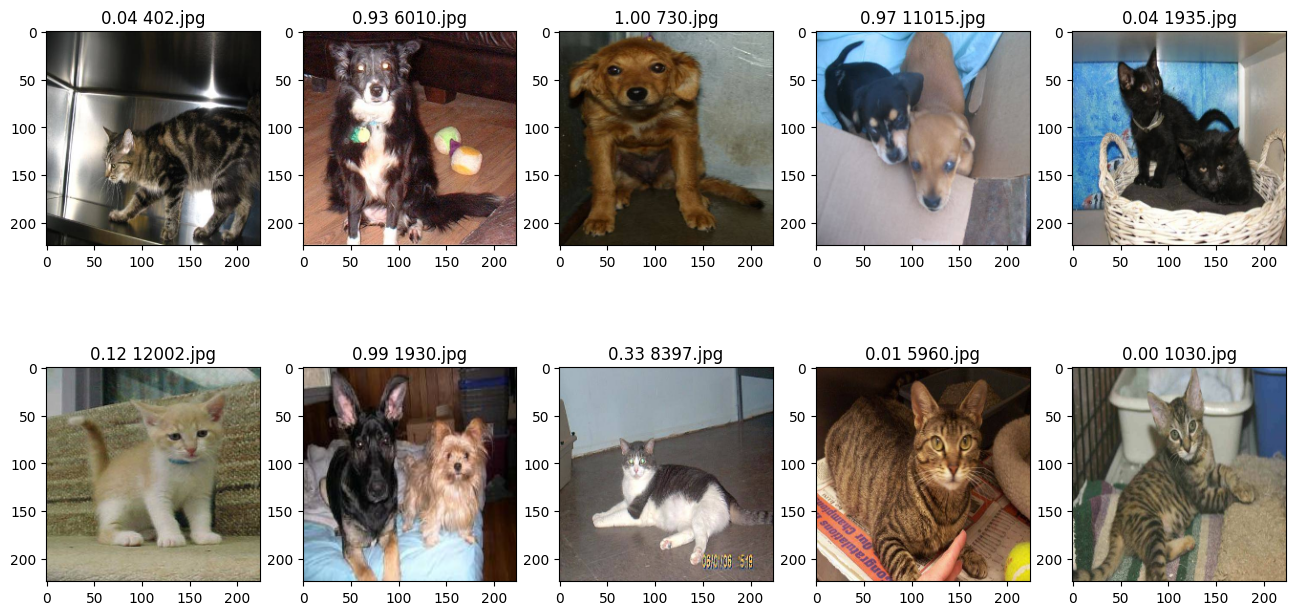

In [22]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [23]:
import re

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

<ipython-input-23-a20658723e90>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))


In [ ]:
# LogLoss = 0.17494

Выводы:
- Обучена модель классификации изображений на 2 класса на основе предобученной модели vgg16 с добавлением в неё полносвязного слоя;
- Log Loss составил 0.17494;
- В целом модель может быть использована в дальнейшем.